# Proyecto Integrado 2020-02

* Arcia Jesus Albero
* Fajardo Daian Paola
* Salazar Carlos Enrique
* Sepulveda Jimenez Hernan

## Importar Librerias
***

In [43]:
import pandas as pd
import numpy as np
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go 
import folium
import re
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import f_classif, f_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import datetime as dt
import seaborn as sns
import scipy.stats as ss
import random
#from pydqc.data_summary import distribution_summary_pretty
import warnings; warnings.filterwarnings(action='once')
#import hdbscan
plt.style.use('ggplot')

In [2]:
#Visualizar filas y columnas completas de los dataframe de Pandas
pd.set_option('display.max_row', None)
pd.set_option('display.max_column', None)
pd.set_option("max_colwidth", None)

## Importar DataSets
***

In [3]:
hurtos_moto = pd.read_csv('https://raw.githubusercontent.com/jaarciah/Proyecto-Integrador-2020-periodo-2/master/Data/Preprocessing/hurto_motos_categorica_exploratorio.csv', sep = ";")
hurto_preprocesado = pd.read_csv('https://raw.githubusercontent.com/jaarciah/Proyecto-Integrador-2020-periodo-2/master/Data/Preprocessing/hurto_motos_dummy_exploratorio.csv', sep = ";")

C:\Users\Paola Fajardo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (24) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Ingenieria de Caracteristicas

### 1. Filter Methods

#### *Eliminar constantes*
Eliminar esas variables que muestran el mismo valor en todas las observaciones, ya que no muestra información adicional

In [4]:
sel = VarianceThreshold(threshold=0)
sel.fit(hurto_preprocesado)

VarianceThreshold(threshold=0)

In [5]:
sum(sel.get_support())

23

In [6]:
constant_variables = hurto_preprocesado.columns[~sel.get_support()]
len(constant_variables)

15

In [7]:
constant_variables

Index(['cantidad', 'grupo_actor', 'actividad_delictiva', 'parentesco',
       'ocupacion', 'discapacidad', 'grupo_especial', 'nivel_academico',
       'testigo', 'conducta', 'caracterizacion', 'articulo_penal',
       'categoria_penal', 'permiso', 'unidad_medida'],
      dtype='object')

In [8]:
#Remover las columnas constantes de varianza 0
for value in constant_variables:
    del hurto_preprocesado[value]
    del hurtos_moto[value]

In [9]:
hurto_preprocesado.shape, hurtos_moto.shape

((64094, 23), (64094, 23))

#### *Eliminar quasi-constant*

In [10]:
sel = VarianceThreshold(threshold=0.001)
sel.fit(hurto_preprocesado) #Encuentra las caracteristicas con poca varianza

VarianceThreshold(threshold=0.001)

In [11]:
sum(sel.get_support()) #True: Caracteristicas con gran variabilidad, False: Caracteristicas con poca variablidad (quasi-constant)

19

In [12]:
quasi_constant = hurto_preprocesado.columns[~sel.get_support()]
len(quasi_constant)

4

In [13]:
quasi_constant

Index(['longitud', 'bien', 'categoria_bien', 'grupo_bien'], dtype='object')

In [14]:
hurtos_moto['bien'].value_counts() / np.float(len(hurtos_moto))

Moto          0.999532
Moto carro    0.000359
Cuatrimoto    0.000094
Carne         0.000016
Name: bien, dtype: float64

In [15]:
hurtos_moto['categoria_bien'].value_counts() / np.float(len(hurtos_moto))

Vehículos de 2 o 4 ruedas    0.999984
Alimento                     0.000016
Name: categoria_bien, dtype: float64

In [16]:
hurtos_moto['grupo_bien'].value_counts() / np.float(len(hurtos_moto))

Vehículo     0.999984
Mercancía    0.000016
Name: grupo_bien, dtype: float64

In [17]:
del hurto_preprocesado['bien']
del hurto_preprocesado['categoria_bien']
del hurto_preprocesado['grupo_bien']

del hurtos_moto['bien']
del hurtos_moto['categoria_bien']
del hurtos_moto['grupo_bien']

In [18]:
hurto_preprocesado.shape, hurtos_moto.shape

((64094, 20), (64094, 20))

#### *Duplicates variables*

In [19]:
hurto_preprocesado_t = pd.DataFrame(hurto_preprocesado.T) # Columnas son filas
hurto_preprocesado_t.duplicated().sum() #Buscar los duplicados

1

In [20]:
hurto_preprocesado_t[hurto_preprocesado_t.duplicated()] #Visualizar los duplicados

0    1    2    3    4    5    6    7    8    9   10    11  \
codigo_barrio  0.0  1.0  2.0  3.0  4.0  5.0  6.0  0.0  7.0  8.0  9.0  10.0   

                 12    13    14    15    16    17    18    19   20    21  \
codigo_barrio  11.0  12.0  13.0  10.0  14.0  15.0  16.0  17.0  8.0  18.0   

                 22    23    24    25    26    27    28    29    30    31  \
codigo_barrio  19.0  20.0  21.0  22.0  23.0  24.0  25.0  19.0  23.0  26.0   

                 32    33   34    35    36    37   38    39    40    41    42  \
codigo_barrio  27.0  28.0  4.0  29.0  30.0  31.0  5.0  32.0  33.0  34.0  30.0   

                 43    44    45    46    47    48    49    50    51    52  \
codigo_barrio  35.0  36.0  37.0  38.0  39.0  40.0  41.0  42.0  43.0  30.0   

                 53    54    55   56    57    58    59    60    61    62  \
codigo_barrio  44.0  45.0  46.0  8.0  47.0  48.0  49.0  19.0  50.0  51.0   

                 63   64    65    66    67    68    69    70    71    72  \
codigo_barrio  52.0  5.0  29.0  53.0  54.0  55.0  56.0  45.0  13.0  57.0   

                 73    74    75    76    77    78    79    80    81    82  \
codigo_barrio  19.0  58.0  59.0  48.0  60.0  29.0  61.0  62.0  63.0  64.0   

                 83    84    85    86    87    88    89   90    91    92  \
codigo_barrio  44.0  65.0  66.0  67.0  68.0  69.0  70.0  9.0  71.0  72.0   

                 93    94    95    96   97    98    99   100   101   102  \
codigo_barrio  12.0  73.0  63.0  74.0  4.0  75.0  76.0  77.0  78.0  79.0   

                103   104   105   106   107   108   109   110   111   112  \
codigo_barrio  80.0  16.0  27.0  81.0  82.0  37.0  83.0  47.0  84.0  62.0   

                113   114   115   116   117   118   119   120   121   122  \
codigo_barrio  85.0  86.0  87.0  88.0  72.0  76.0  28.0  70.0  80.0  30.0   

                123   124   125   126   127   128   129   130   131   132  \
codigo_barrio  88.0  89.0  54.0  54.0  90.0  91.0  29.0  92.0  93.0  94.0   

                133   134   135   136   137   138   139   140   141    142  \
codigo_barrio  95.0  27.0  23.0  96.0  97.0  98.0  99.0  27.0  44.0  100.0   

                 143    144    145   146   147    148  149    150    151  \
codigo_barrio  101.0  102.0  103.0  35.0  70.0  104.0  2.0  105.0  106.0   

                152   153   154   155   156    157  158   159    160   161  \
codigo_barrio  63.0  40.0  29.0  41.0  70.0  107.0  8.0  84.0  108.0  26.0   

                162    163   164    165    166    167   168  169   170    171  \
codigo_barrio  46.0  109.0  15.0  110.0  111.0  106.0  19.0  5.0  19.0  112.0   

                 172   173    174   175  176   177   178   179   180    181  \
codigo_barrio  113.0  37.0  114.0  30.0  3.0  51.0  30.0  45.0  26.0  115.0   

                 182   183   184   185  186   187   188    189   190   191  \
codigo_barrio  116.0  40.0  45.0  24.0  5.0  24.0  33.0  117.0  61.0  64.0   

                 192    193    194   195    196   197  198   199   200    201  \
codigo_barrio  118.0  119.0  120.0  69.0  121.0  53.0  1.0  21.0  83.0  122.0   

                 202    203    204   205    206   207    208   209   210  \
codigo_barrio  117.0  123.0  124.0  27.0  125.0  90.0  126.0  90.0  54.0   

                211    212    213    214    215  216   217    218   219   220  \
codigo_barrio  42.0  109.0  127.0  122.0  128.0  5.0  49.0  129.0  12.0  11.0   

                221    222   223    224    225  226    227    228   229   230  \
codigo_barrio  95.0  130.0  77.0  131.0  132.0  4.0  124.0  133.0  63.0  74.0   

                231   232    233    234   235    236    237    238   239  \
codigo_barrio  48.0  38.0  134.0  135.0  90.0  125.0  136.0  137.0  76.0   

                240  241    242    243  244    245    246    247   248   249  \
codigo_barrio  27.0  9.0  138.0  139.0  5.0  140.0  141.0  142.0  41.0  16.0   

                 250   251    252    253    254   255   256    257    258  \
codigo_barrio  115.0  7

In [21]:
duplicated_features = hurto_preprocesado_t[hurto_preprocesado_t.duplicated()].index.values
duplicated_features = pd.DataFrame(duplicated_features)

In [22]:
data_unique = duplicated_features.drop_duplicates(keep='first').T # Eliminar lod duplicados
data_unique.shape # Volver el dataset como estaba anteriormente

(1, 1)

In [23]:
duplicated_features = [col for col in pd.DataFrame(duplicated_features).columns if col not in data_unique.columns] #Identificar los duplicados antes de ser eliminados. 
duplicated_features 

[]

El código de barrio es una variable duplicada, ya que esta tiene una correlación del 100 con el nombre de barrio

In [24]:
hurto_preprocesado.shape, hurtos_moto.shape

((64094, 20), (64094, 20))

### 2. Correlacion

#### *Correlación cramer para variables categoricas*

In [39]:
hurtos_moto2 = hurtos_moto[['sexo','edad','estado_civil','medio_transporte','modalidad','conducta_especial','arma_medio','nombre_barrio','codigo_barrio','codigo_comuna','lugar','sede_receptora','modelo','color','anho','mes','dia']].copy()
n_filas, n_columnas = hurtos_moto2.shape

def cramers_v(x,y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

matriz_corr = np.zeros((n_columnas,n_columnas))
names = hurtos_moto2.columns

In [40]:
i = 0
j = 0
for x in names:
    j = 0
    for k in names:
        def_y = cramers_v(hurtos_moto2[x],hurtos_moto2[k])
        matriz_corr[j][i] = def_y
       # print(matriz_corr)
        j = j + 1
    i = i + 1

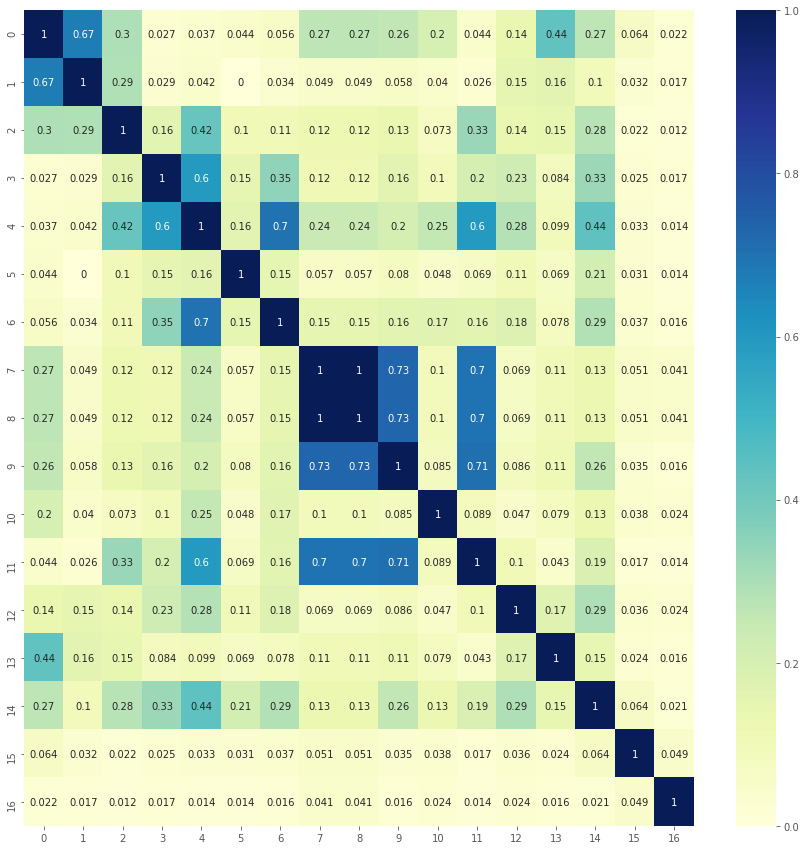

In [41]:
plt.figure(figsize=(15,15))
sns.heatmap(matriz_corr, annot=True, cmap='YlGnBu')

In [42]:
hurtos_moto2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64869 entries, 0 to 64868
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sexo               64869 non-null  object 
 1   edad               64869 non-null  float64
 2   estado_civil       64869 non-null  object 
 3   medio_transporte   64869 non-null  object 
 4   modalidad          64869 non-null  object 
 5   conducta_especial  64869 non-null  object 
 6   arma_medio         64869 non-null  object 
 7   nombre_barrio      64869 non-null  object 
 8   codigo_barrio      64869 non-null  object 
 9   codigo_comuna      64869 non-null  object 
 10  lugar              64869 non-null  object 
 11  sede_receptora     64869 non-null  object 
 12  modelo             64869 non-null  int64  
 13  color              64869 non-null  object 
 14  anho               64869 non-null  int64  
 15  mes                64869 non-null  int64  
 16  dia                648

Se eliminan esas variables categoricas que son mayores al 90%, por lo que se debe considerar cuales de las variables Codigo de bario y Nombre de Barrio deberian eliminarse.
Esta decision dependera de la ganancia de información que estas variables dan al modelo

#### *Correlación con valore defoult python*

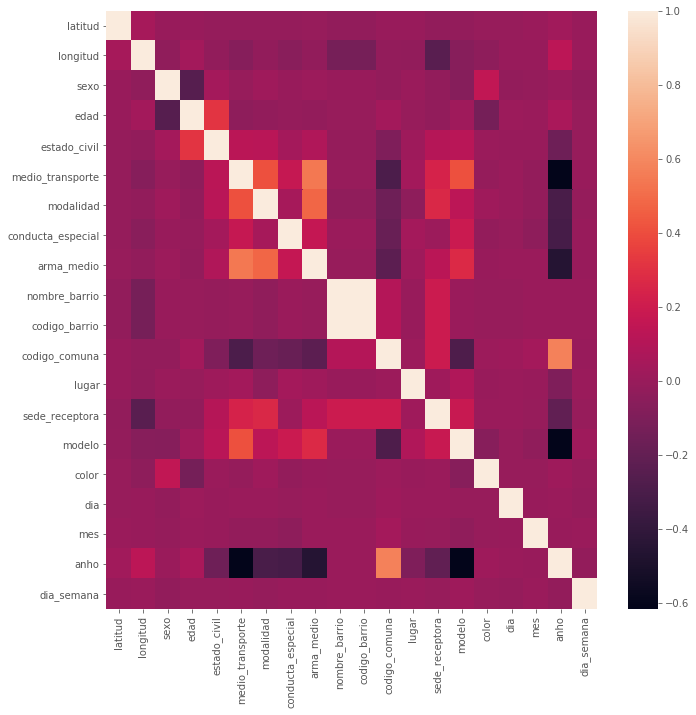

In [25]:
corrmat = hurto_preprocesado.corr()
fig, ax = plt.subplots()
fig.set_size_inches(11,11)
sns.heatmap(corrmat)

#### *Correlación por el metodo Brute force*

In [26]:
def correlation(dataset, threshold):
    col_corr = set() #conjunto de todos los nombres de las columnas correlacionadas
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [27]:
corr_features = correlation(hurto_preprocesado, 0.8)
len(set(corr_features))

1

In [28]:
corr_features

{'codigo_barrio'}

#### *Correlación con pearson corr coefficient*

In [29]:
corrmat = hurto_preprocesado.corr()
corrmat = corrmat.abs().unstack() #Valor absoluto del coeficiente de correlación 
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.8]
corrmat = corrmat[corrmat < 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat.head()

Empty DataFrame
Columns: [feature1, feature2, corr]
Index: []

In [30]:
#Encontrar los grupos de caracteristicas correlacionadas
grouped_features_ls = []
correlated_group = []

for features in corrmat.feature1.unique():
    if features not in grouped_feature_ls:
        
        #Encontrar las caractersticas correlacionadas
        correlatd_block = corrmat[corrmat.feature1 == feature]
        grouped_features_ls = grouped_features_ls + list(correlated_block.feature2.unique()) + [feature]
        
        correlated_group.append(correlatd_block)

print("Se encontro {} grupos correlacionados".format(len(correlated_group)))
print("{} Es el total de caracteristicas no correlacionadas".format(hurto_preprocesado.shape[1]))

Se encontro 0 grupos correlacionados
20 Es el total de caracteristicas no correlacionadas


In [31]:
#Con el siguiente codigo se puede visualizar los grupos correlacionados
for group in correlated_group:
    print(group)
    print()

In [32]:
#Para eliminar las variables correlacionadas
hurto_preprocesado.drop(labels=corr_features, axis=1, inplace=True)
hurtos_moto.drop(labels=corr_features, axis=1, inplace=True)

In [33]:
hurto_preprocesado.shape, hurtos_moto.shape

((64094, 19), (64094, 19))

### 3. Statistical Mesuraments

#### *Mutual Information*

Revisar la dependiencia de dos variables

$I(X;Y) = \sum_{y\epsilon Y} \sum_{x\epsilon X} {p(X,Y)} (x,y) log (\frac{p(X,Y) (x,y)}{pX(x) pY(y)})$

Si X y Y son independientes entonces este sera igual a 0, 
Si x es deterministico de Y enotonces X sera diferente de 0

In [34]:
hurto_preprocesado_mi = hurto_preprocesado.copy()
hurtos_moto_mi = hurtos_moto.copy()

In [35]:
x = hurto_preprocesado_mi.drop(['modalidad'], axis=1)
y = hurto_preprocesado_mi[["modalidad"]]

In [36]:
mi = mutual_info_classif(x, y)
mi #Nos muestra mutual information de cada caracteristica contra el objetivo 

C:\Users\Paola Fajardo\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


array([0.09630142, 0.10183531, 0.        , 0.00545338, 0.11174722,
       0.35234075, 0.03011002, 0.59807879, 0.06323746, 0.04393439,
       0.07353081, 0.19002318, 0.07000445, 0.0087512 , 0.0021162 ,
       0.        , 0.13111961, 0.00381033])

Text(0, 0.5, 'Mutual Information')

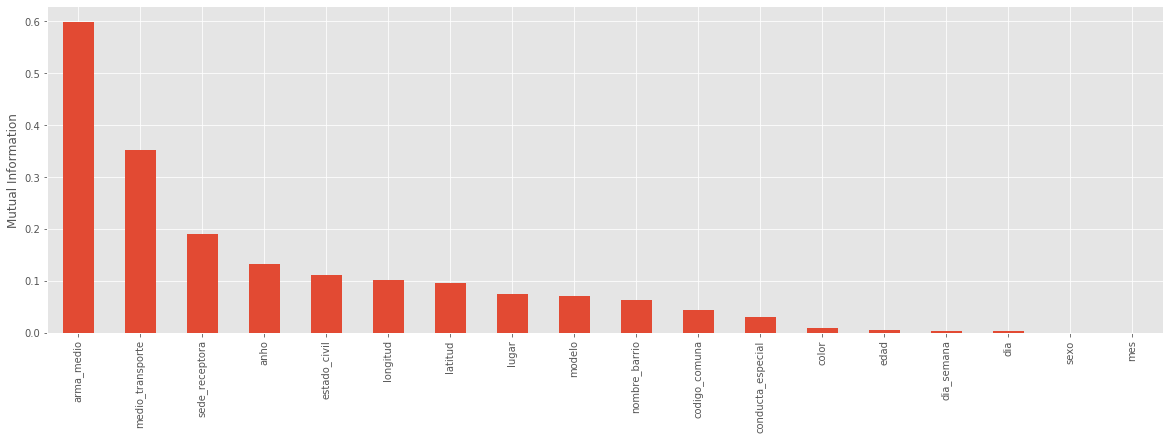

In [37]:
mi = pd.Series(mi)
mi.index = x.columns
mi.sort_values(ascending=False).plot.bar(figsize=(20, 6))
plt.ylabel('Mutual Information')

In [38]:
mi.sort_values(ascending=False)

arma_medio           0.598079
medio_transporte     0.352341
sede_receptora       0.190023
anho                 0.131120
estado_civil         0.111747
longitud             0.101835
latitud              0.096301
lugar                0.073531
modelo               0.070004
nombre_barrio        0.063237
codigo_comuna        0.043934
conducta_especial    0.030110
color                0.008751
edad                 0.005453
dia_semana           0.003810
dia                  0.002116
sexo                 0.000000
mes                  0.000000
dtype: float64

Las variables que aportar mayor predicción contra la modalidad de hurto. Como lo es el arma y medio transporte.Y tambien se puede ver a la derecha de la grafica existen unos caracteristicas que no le estan aportando predicción al modelo.
Para efectos del modelo se eliminaran esas variables que se encuentran con un aporte de información del 0.05%

In [39]:
del hurto_preprocesado['sexo']
del hurto_preprocesado['edad']
del hurto_preprocesado['color']
del hurto_preprocesado['conducta_especial']

del hurtos_moto['sexo']
del hurtos_moto['edad']
del hurtos_moto['color']
del hurtos_moto['conducta_especial']

In [40]:
hurto_preprocesado.shape, hurtos_moto.shape

((64094, 15), (64094, 15))

#### *Anova*

In [58]:
u = f_regression(x, y)
u

C:\Users\Paola Fajardo\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


(array([1.30518630e+01, 3.73633191e+01, 3.89873602e+01, 4.21896757e+01,
        9.28596880e+02, 1.30403225e+04, 1.58653124e+02, 1.94117863e+04,
        7.76691172e+01, 1.63132044e+03, 1.07066515e+02, 4.89501953e+03,
        1.16825960e+03, 3.51224620e+01, 1.22791227e+00, 2.82954538e+01,
        6.43263580e+03, 8.44050222e+00]),
 array([3.03214401e-004, 9.86125550e-010, 4.29223055e-010, 8.34402369e-011,
        1.67965622e-202, 0.00000000e+000, 2.46057745e-036, 0.00000000e+000,
        1.24804908e-018, 0.00000000e+000, 4.50513126e-025, 0.00000000e+000,
        9.36947936e-254, 3.11185899e-009, 2.67817595e-001, 1.04488656e-007,
        0.00000000e+000, 3.67080341e-003]))

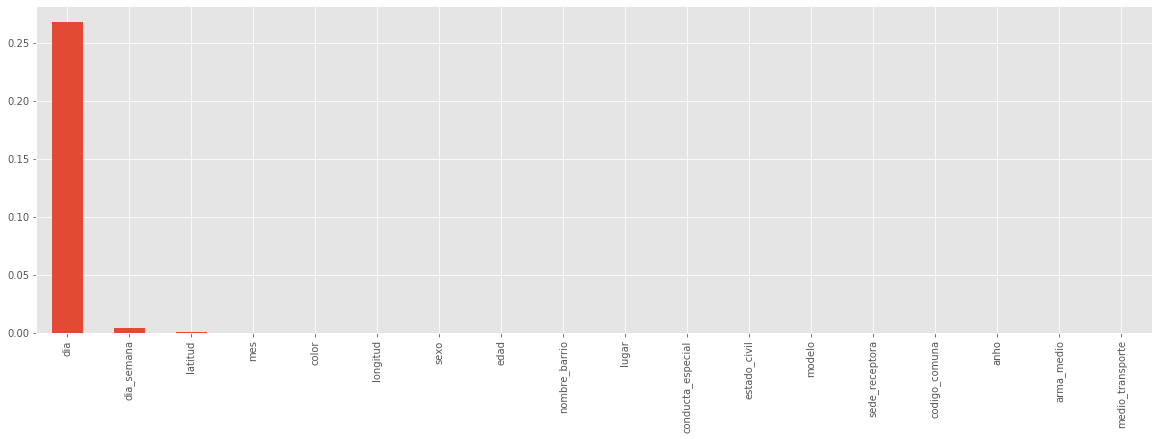

In [60]:
u = pd.Series(u[1])
u.index = x.columns
u.sort_values(ascending=False).plot.bar(figsize=(20, 6))

Entre mas bajo el P value, mas predecible sera la variable, por lo que la Variable dia al tener un p-value mayor a 0.05, no aportan al modelo al predecir la modalidad de hurto

### 4. Step Forward Feature Selection

In [122]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

C:\Users\Paola Fajardo\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [124]:
hurto_preprocesado.columns

Index(['latitud', 'longitud', 'estado_civil', 'medio_transporte', 'modalidad',
       'arma_medio', 'nombre_barrio', 'codigo_comuna', 'lugar',
       'sede_receptora', 'modelo', 'dia', 'mes', 'anho'],
      dtype='object')

In [125]:
namesX = ['latitud', 'longitud', 'estado_civil', 'medio_transporte', 'modalidad',
       'arma_medio', 'nombre_barrio', 'codigo_comuna', 'lugar',
       'sede_receptora', 'modelo', 'dia', 'mes', 'anho']

x = hurto_preprocesado[namesX]
y = hurto_preprocesado['modalidad']

In [127]:
model1 = Pipeline([('randomF', RandomForestClassifier())])

params = {'randomF__n_estimators':(100,150,200),
          'randomF__criterion':(["gini", "entropy"]),
          'randomF__min_samples_split':(2,5,10)
#           'random__max_features':(["auto","sqrt", "log2"])
         }

In [128]:
grid1 = GridSearchCV(model1, params, cv=5)

In [129]:
grid1.fit(x,y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('randomF', RandomForestClassifier())]),
             param_grid={'randomF__criterion': ['gini', 'entropy'],
                         'randomF__min_samples_split': (2, 5, 10),
                         'randomF__n_estimators': (100, 150, 200)})

In [130]:
grid1.best_score_

0.9948513729893961

In [131]:
grid1.best_params_

{'randomF__criterion': 'gini',
 'randomF__min_samples_split': 5,
 'randomF__n_estimators': 150}

In [132]:
sfs1 = SFS(RandomForestClassifier (n_jobs=4), #Seleccionar las variables con random forest y con 4 procesadore
          k_features = 19, #Se quiere seleccionar el numeor de caracteristicas
          forward = True,
          floating = False, 
          verbose = 2, 
          scoring = 'roc_auc', #Basados en roc auc
          cv = 3) #Cross Validation

In [133]:
corrmat = hurto_preprocesado.corr()
corrmat = corrmat.abs().unstack() #Valor absoluto del coeficiente de correlación 
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.1]
corrmat = corrmat[corrmat < 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat.head(5)

feature1          feature2      corr
0              anho  medio_transporte  0.615776
1  medio_transporte              anho  0.615776
2              anho            modelo  0.614053
3            modelo              anho  0.614053
4              anho     codigo_comuna  0.572892

In [134]:
hurto_sfs = hurto_preprocesado.copy()
#del hurto_sfs['codigo_comuna']

### Generar archivo con las variables seleccionadas

In [41]:
hurto_preprocesado.to_csv("hurto_motos_dummy_ingCaracteristicas.csv", sep=";", index=False)